# Przetwarzanie wstępne i czyszczenie danych

Spis treści:
1) ustalenie rodzajów atrybutów
2) wskazanie atrybutów celu
3) ustalenie i aplikacja strategii radzenia sobie z wartościami pustymi
4) identyfikacja i odrzucenie pomiarów odstających
5) wstępny wybór algorytmu eksploracji danych
6) przygotowanie atrybutów o konkretnym typie do eksploracji (normalizacja, zamiana na wektor, itd.)

**Import niezbędnych bibliotek**

In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

**Wczytanie i wyświetlenie danych**

In [428]:
df = pd.read_csv("data/Telco_customer_churn.csv")

df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### **1. Ustalenie rodzajów atrybutów**

**Wyświetlenie podstawowych statystyk**

In [429]:
# Kategoryczne
num_categorical = len(df.select_dtypes(include=['category']).columns)

# Obiektowe (np. stringi)
num_object = len(df.select_dtypes(include=['object']).columns)

# Liczbowe
num_numerical = len(df.select_dtypes(include=[np.number]).columns)

print(f"Kategoryczne: {num_categorical}")
print(f"Obiektowe: {num_object}")
print(f"Liczbowe: {num_numerical}")
print(f"Łącznie: {len(df.columns)}")

Kategoryczne: 0
Obiektowe: 24
Liczbowe: 9
Łącznie: 33


**Atrybuty kategoryczne / tekstowe**

In [430]:
df.describe(include=['object'])

,CustomerID,Country,State,City,Lat Long,Gender,Senior Citizen,Partner,Dependents,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Total Charges,Churn Label,Churn Reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,1869
unique,7043,1,1,1129,1652,2,2,2,2,2,...,3,3,3,3,3,2,4,6531,2,20
top,3186-AJIEK,United States,California,Los Angeles,"34.159534, -116.425984",Male,No,No,No,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No,Attitude of support person
freq,1,7043,7043,305,5,3555,5901,3641,5416,6361,...,3095,3473,2810,2785,3875,4171,2365,11,5174,192


Atrybut Total Charges został uznany za tekstowy bo przyjmuje 11 razy wartość spacji (' ') w csv.
Zamienimy tą wartość na 0.

In [431]:
df.describe(include=[np.number])

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


**Atrybuty numeryczne**:

Count, Latitude, Longitude, Tenure Months, Monthly Charges, Total Charges, Churn Score, CLTV
Churn

**Atrybuty kategoryczne**:

Country, State, Multiple lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Payment method, Churn Label, Churn Value,

**Atrybuty binarne**:

Gender, Senior Citizen, Partner, Dependents, Phone Service, Paperless Billing,

**Atrybuty tekstowe**:

CustomerID, City, Zip Code, Lat Long, Churn Reason

**Wybór atrybutów**

In [432]:
len(df["Tenure Months"].unique())

73

Odrzucamy: CustomerID (nic nam nie daje), Count, Country (tylko jedna wartość), State (tylko jedna wartość), City, Lat long, Latitude, Longitude, Churn label (zostawimy churn value)

**Dodanie atrybutu z liczbą mieszkańców miasta**

In [433]:
import json

# Load from file
with open("data/population_of_cities.json", "r") as f:
    loaded_data = json.load(f)

population = []
for city in df['City']:
    population.append(loaded_data[city])

df['City Population'] = population

In [434]:
print(len(df.columns))
df = df.drop(["CustomerID", "Count", "Country", "State", "City", "Lat Long", "Latitude", "Longitude", "Churn Label"], axis=1)
len(df.columns)

34


25

### **2. Wskazanie atrybutów celu**

Churn value.

### **3. Ustalenie i aplikacja strategii radzenia sobie z wartościami pustymi**

Wiersze z wartościami pustymi (NaN) należy odrzucić lub zastąpić wartości dla danego atrybutu np. średnią arytmetyczną lub medianą na danym atrybucie.

**Zastąpienie wartości pustych w kolumnie Churn reason wartością neutralną**

In [435]:
df.astype('object').describe(include='all')

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason,City Population
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043.00,7043,7043,7043,7043,1869,7043
unique,1652,2,2,2,2,73,2,3,3,3,...,3,2,4,1585.00,6531,2,85,3438,20,984
top,92284,Male,No,No,No,1,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,20.05,20.2,0,80,5546,Attitude of support person,3898747
freq,5,3555,5901,3641,5416,613,6361,3390,3096,3498,...,3875,4171,2365,61.00,11,5174,151,8,192,305


Wszystkie atrybuty są równo liczne poza Churn Reason, większość wierszy ma wartość null na tym atrybucie. Zatem w wierszach w których jest null zapisujemy wartość neutralną "Not provided."

In [436]:
df["Churn Reason"] = df["Churn Reason"].fillna("Not provided.")

**Zastąpienie spacji w kolumnie Total Charges wartością 0 (przez 0 miesięcy byli klientami firmy więc zerowe koszty całkowite)**

In [437]:
df["Total Charges"] = df["Total Charges"].replace(' ', 0)
df["Total Charges"] = df["Total Charges"].astype(float)

**Macierz korelacji**

<Axes: >

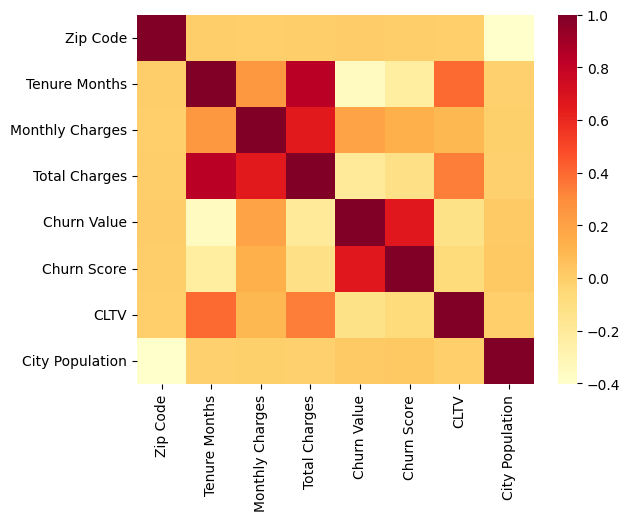

In [438]:
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='YlOrRd')

Odrzucamy atrybut Total Charges ze względu na silną korelację z Tenure Months - nie będzie on informatywny

In [439]:
df = df.drop(["Total Charges"], axis=1)
len(df.columns)

24

In [440]:
df.describe(include=['object'])

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn Reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,21
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Not provided.
freq,3555,5901,3641,5416,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [441]:
df.describe(include=[np.number])

,Zip Code,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV,City Population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7.043000e+03
mean,93521.964646,32.371149,64.761692,0.265370,58.699418,4400.295755,2.927982e+05
std,1865.794555,24.559481,30.090047,0.441561,21.525131,1183.057152,8.117031e+05
min,90001.000000,0.000000,18.250000,0.000000,5.000000,2003.000000,4.000000e+00
25%,92102.000000,9.000000,35.500000,0.000000,40.000000,3469.000000,1.519000e+03
50%,93552.000000,29.000000,70.350000,0.000000,61.000000,4527.000000,2.958100e+04
75%,95351.000000,55.000000,89.850000,1.000000,75.000000,5380.500000,1.260900e+05
max,96161.000000,72.000000,118.750000,1.000000,100.000000,6500.000000,3.898747e+06


### **4. Identyfikacja i odrzucenie pomiarów odstających**

**Z użyciem IQR**

In [442]:
for column in df.select_dtypes(include=['number']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Value,Churn Score,CLTV,Churn Reason,City Population
18,90211,Female,No,No,Yes,9,Yes,Yes,Fiber optic,No,...,Yes,Month-to-month,No,Electronic check,94.40,1,96,5571,Price too high,32701
19,90255,Female,No,No,Yes,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,79.35,1,87,2483,Product dissatisfaction,52666
20,90262,Female,No,Yes,Yes,7,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Bank transfer (automatic),75.15,1,70,3457,Service dissatisfaction,67265
21,90292,Female,No,No,Yes,12,Yes,Yes,Fiber optic,Yes,...,No,Month-to-month,Yes,Electronic check,78.95,1,86,5806,Lack of self-service on Website,11373
22,90301,Male,No,No,No,5,Yes,No,No,No internet service,...,No internet service,Month-to-month,No,Mailed check,21.05,1,66,2604,Network reliability,107762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,92285,Female,No,No,No,72,Yes,No,No,No internet service,...,No internet service,Two year,Yes,Bank transfer (automatic),21.15,0,45,5306,Not provided.,2982
7039,92301,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,One year,Yes,Mailed check,84.80,0,59,2140,Not provided.,38046
7040,92304,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,One year,Yes,Credit card (automatic),103.20,0,71,5560,Not provided.,4
7041,92305,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,Month-to-month,Yes,Electronic check,29.60,0,59,2793,Not provided.,424


array([[<Axes: title={'center': 'Zip Code'}>,
        <Axes: title={'center': 'Tenure Months'}>,
        <Axes: title={'center': 'Monthly Charges'}>],
       [<Axes: title={'center': 'Churn Value'}>,
        <Axes: title={'center': 'Churn Score'}>,
        <Axes: title={'center': 'CLTV'}>],
       [<Axes: title={'center': 'City Population'}>, <Axes: >, <Axes: >]],
      dtype=object)

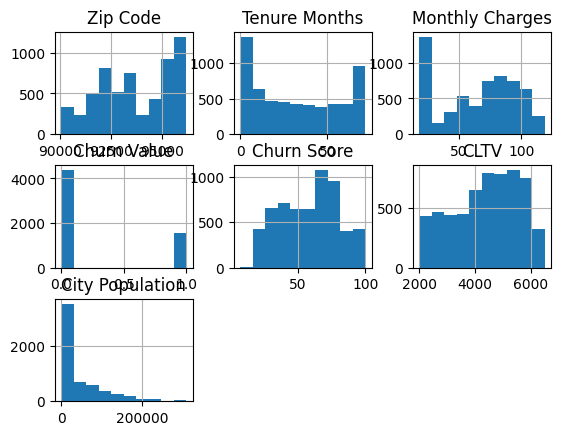

In [443]:
df.hist()

### **5. Przygotowanie atrybutów o konkretnym typie do eksploracji**

**Zamiana Churn Value na target**

In [444]:
df.columns

Index(['Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Value', 'Churn Score',
       'CLTV', 'Churn Reason', 'City Population'],
      dtype='object')

In [445]:
df.rename(columns={'Churn Value':'target'}, inplace=True)

In [446]:
df.columns

Index(['Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'target', 'Churn Score', 'CLTV',
       'Churn Reason', 'City Population'],
      dtype='object')

In [447]:
df.select_dtypes(include=['object']).columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Churn Reason'],
      dtype='object')

**One-Hot Encoding:**

In [448]:
categorical_cols = ['Gender', 'Internet Service', 'Multiple Lines', 'Contract', 'Payment Method', 'Churn Reason', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

df_encoded = preprocessor.fit_transform(df)
df_encoded = pd.DataFrame(df_encoded, columns=preprocessor.get_feature_names_out())
df_encoded.columns = df_encoded.columns.str.replace('remainder__', '')
df_encoded.head()

,cat__Gender_Male,cat__Internet Service_Fiber optic,cat__Internet Service_No,cat__Multiple Lines_No phone service,cat__Multiple Lines_Yes,cat__Contract_One year,cat__Contract_Two year,cat__Payment Method_Credit card (automatic),cat__Payment Method_Electronic check,cat__Payment Method_Mailed check,...,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,target,Churn Score,CLTV,City Population
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,No,Yes,9,Yes,No,94.4,1,96,5571,32701
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,No,Yes,1,Yes,Yes,79.35,1,87,2483,52666
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Yes,Yes,7,Yes,Yes,75.15,1,70,3457,67265
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,No,Yes,12,Yes,Yes,78.95,1,86,5806,11373
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,No,No,5,Yes,No,21.05,1,66,2604,107762


In [449]:
df_encoded.columns

Index(['cat__Gender_Male', 'cat__Internet Service_Fiber optic',
       'cat__Internet Service_No', 'cat__Multiple Lines_No phone service',
       'cat__Multiple Lines_Yes', 'cat__Contract_One year',
       'cat__Contract_Two year', 'cat__Payment Method_Credit card (automatic)',
       'cat__Payment Method_Electronic check',
       'cat__Payment Method_Mailed check',
       'cat__Churn Reason_Attitude of support person',
       'cat__Churn Reason_Competitor had better devices',
       'cat__Churn Reason_Competitor made better offer',
       'cat__Churn Reason_Competitor offered higher download speeds',
       'cat__Churn Reason_Competitor offered more data',
       'cat__Churn Reason_Deceased', 'cat__Churn Reason_Don't know',
       'cat__Churn Reason_Extra data charges',
       'cat__Churn Reason_Lack of affordable download/upload speed',
       'cat__Churn Reason_Lack of self-service on Website',
       'cat__Churn Reason_Limited range of services',
       'cat__Churn Reason_Long dist

**Mapowanie label encoding, zmiennych kategorialnych binarnych na numeryczne:**

In [450]:
encoder = LabelEncoder()
df_encoded['Senior Citizen'] = encoder.fit_transform(df_encoded['Senior Citizen'])
df_encoded['Partner'] = encoder.fit_transform(df_encoded['Partner'])
df_encoded['Dependents'] = encoder.fit_transform(df_encoded['Dependents'])
df_encoded['Phone Service'] = encoder.fit_transform(df_encoded['Phone Service'])
df_encoded['Paperless Billing'] = encoder.fit_transform(df_encoded['Paperless Billing'])

In [451]:
df_encoded.describe(include='all')

,cat__Gender_Male,cat__Internet Service_Fiber optic,cat__Internet Service_No,cat__Multiple Lines_No phone service,cat__Multiple Lines_Yes,cat__Contract_One year,cat__Contract_Two year,cat__Payment Method_Credit card (automatic),cat__Payment Method_Electronic check,cat__Payment Method_Mailed check,...,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,target,Churn Score,CLTV,City Population
count,5944.0,5944.0,5944.0,5944.0,5944.0,5944.0,5944.0,5944.0,5944.0,5944.0,...,5944.000000,5944.000000,5944.0,5944.000000,5944.000000,5944.00,5944.0,5944.0,5944.0,5944.0
unique,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,73.0,NaN,NaN,1519.00,2.0,84.0,3210.0,972.0
top,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,NaN,NaN,20.05,0.0,80.0,5546.0,100.0
freq,2985.0,3311.0,4653.0,5365.0,3447.0,4700.0,4501.0,4661.0,3950.0,4597.0,...,NaN,NaN,518.0,NaN,NaN,54.00,4375.0,130.0,8.0,66.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.485532,0.233513,NaN,0.902591,0.595054,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.499833,0.423101,NaN,0.296539,0.490923,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN


### **6. Wybór miar ewaluacji**

**Kluczowe miary ewaluacji dla naszego problemu:**


*   accuracy - odsetek poprawnie sklasyfikowanych przykładów -> Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
*   recall - ilu z tych którzy faktycznie odeszli udało się wykryć (chcemy wykrywać jak najwięcej odejść i móc na nie jakoś zareagować) -> Recall = $\frac{TP}{TP + FN}$
*   precision - z tych, których przewidziano jako rezygnujących, ilu rzeczywiście odeszło (może wskazywać czy nie wystąpi problem z "fałszywym alarmem") -> Precision = $\frac{TP}{TP + FP}$



### **7. Wstępny wybór algorytmu eksploracji danych**

klasyfikacja klasy target:

1 - zrezygnował,

0 - nie zrezygnował

**Wyznaczenie atrybutu z najwyższą korelacją z target - wstępna analiza**

In [452]:
df_encoded["target"].value_counts()

,count
target,
0,4375
1,1569


### **8. Wybór strategii ewaluacyjnej**

In [453]:
def convert_to_float(X):
    return X.astype(float)

In [454]:
for col in df_encoded.columns:
  df_encoded[col] = convert_to_float(df_encoded[col])

Wybieramy **Stratified K-Fold Cross-Validation**, aby zachować proporcje klas w zbiorach treningowym i testowym.

In [455]:
X = df_encoded.drop(columns='target')
y = df_encoded['target']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"Fold {fold + 1}:")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print("Train target distribution:")
    print(y_train.value_counts())
    print("Test target distribution:")
    print(y_test.value_counts())
    print()

Fold 1:
Train size: 4755, Test size: 1189
Train target distribution:
target
0.0    3500
1.0    1255
Name: count, dtype: int64
Test target distribution:
target
0.0    875
1.0    314
Name: count, dtype: int64

Fold 2:
Train size: 4755, Test size: 1189
Train target distribution:
target
0.0    3500
1.0    1255
Name: count, dtype: int64
Test target distribution:
target
0.0    875
1.0    314
Name: count, dtype: int64

Fold 3:
Train size: 4755, Test size: 1189
Train target distribution:
target
0.0    3500
1.0    1255
Name: count, dtype: int64
Test target distribution:
target
0.0    875
1.0    314
Name: count, dtype: int64

Fold 4:
Train size: 4755, Test size: 1189
Train target distribution:
target
0.0    3500
1.0    1255
Name: count, dtype: int64
Test target distribution:
target
0.0    875
1.0    314
Name: count, dtype: int64

Fold 5:
Train size: 4756, Test size: 1188
Train target distribution:
target
0.0    3500
1.0    1256
Name: count, dtype: int64
Test target distribution:
target
0.0    87